# Neuromatch Academy: Week 2, Day 3, Tutorial 3
# Linear Dynamical System - Kalman Filters

Tutorial by Caroline Haimerl and Byron Galbraith

**Useful reference:**
- Roweis, Ghahramani (1998): A unifying review of linear Gaussian Models
- Bishop (2006): Pattern Recognition and Machine Learning

**Acknowledgement**

This tutorial is based on code originally created for Dr. Cristina Savin's *Probabilistic Time Series* class at the Center for Data Science, New York University

In [1]:
#@title Install External Libraries
# Install PyKalman (https://pykalman.github.io/)
!pip install pykalman

     |██████████████████▋             | 133 kB 7.0 MB/s eta 0:00:01

     |████████████████████████████████| 228 kB 7.0 MB/s 


 done
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48462 sha256=9333c23cd8f876c47348f0ea0931af8b775612706b48743128df5e7b952bc254
  Stored in directory: /home/runner/.cache/pip/wheels/6a/04/02/2dda6ea59c66d9e685affc8af3a31ad3a5d87b7311689efce6
Successfully built pykalman


In [2]:
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
from pykalman import KalmanFilter 
import requests
from scipy import stats

import ipywidgets as widgets

In [3]:
#@title Download Data
with open('/share/dataset/W2D3/nma_mit_eyetracking_2009.npz', 'rb') as f:
    r = f.read()
eye_tracking = np.load(BytesIO(r), allow_pickle=True)
et_images = [plt.imread(BytesIO(stim), format='JPG') for stim in eye_tracking['stimuli']]
et_subjects = eye_tracking['subjects']

In [4]:
#@title Figure Settings
%matplotlib inline
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
%config InlineBackend.figure_format = 'retina'

In [5]:
#@title Helper Functions
def plot_kalman_(state, observation, title='LDS'):
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))
  
  ax1.plot(state[:, 0], state[:, 1], 'g-', label='true latent')
  ax1.plot(observation[:, 0], observation[:, 1], 'k.', label='data')
  ax1.set(title=title, xlabel='X position', ylabel='Y position')
  ax1.legend()

  ax2.plot(state[:, 0], observation[:, 0], '.k', label='dim 1')
  ax2.plot(state[:, 1], observation[:, 1], '.', color='grey', label='dim 2')
  ax2.set(title='correlation', xlabel='latent', ylabel='observed')
  ax2.legend()


def plot_kalman(x, y, nx, ny, kx=None, ky=None, color="r-", label=None, title='LDS', ax=None):
  """
  Plot the trajectory
  """
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))
    plotdata = True
  else:
    plotdata = False
    
  if kx is not None and ky is not None:
    if plotdata:
      ax[0].plot(x, y, 'g-', label='true latent')
      ax[0].plot(nx, ny, 'k.', label='data')
    ax[0].plot(kx, ky, color, label=label)

    ax[1].plot(x, kx, '.', color=color, label='latent dim 1')
    ax[1].plot(y, ky, 'x', color=color, label='latent dim 2')
    ax[1].set_xlabel('real latent')
    ax[1].set_ylabel('estimated latent')
    ax[1].legend()
  else:
    ax[0].plot(x, y, 'g-', label='true latent')
    ax[0].plot(nx, ny, 'k.', label='data')
    ax[1].plot(x, nx, '.k', label='dim 1')
    ax[1].plot(y, ny, '.', color='grey', label='dim 2')
    ax[1].set_xlabel('latent')
    ax[1].set_ylabel('observed')
    ax[1].legend()

  ax[0].set_xlabel('X position')
  ax[0].set_ylabel('Y position')
  ax[0].set_title(title)
  # ax[0].set_aspect(1)
  ax[1].set_aspect(1)
  ax[1].set_title('correlation')

  ax[0].legend()
  return ax


def print_parameters(kf_model, need_params=None, evals=False):
  """
  Function that prints out the parameters for a Kalman Filter
  @param - kf_model : the model object
  @param - need_params : a list of string
  """
  if evals:
    if need_params is None:
      need_params1 = ['transition_matrices', 'transition_covariance', 'observation_covariance',
                      'initial_state_covariance']
      need_params2 = ['observation_matrices', 'initial_state_mean']
    
    for param in need_params1:
      tmp = np.linalg.eig(getattr(kf_model, param))[0]
      print("{0} (shape = {2})\n   {1}\n".format(param, tmp, tmp.shape))
    
    for param in need_params2:
      print("{0} (shape = {2})\n   {1}\n".format(param, getattr(kf_model, param), getattr(kf_model, param).shape))
  else:
    if need_params is None:
      need_params = ['transition_matrices', 'observation_matrices', 'transition_covariance',
                     'observation_covariance',
                     'initial_state_mean', 'initial_state_covariance']
    for param in need_params:
      print("{0} (shape = {2})\n   {1}\n".format(param, getattr(kf_model, param), getattr(kf_model, param).shape))


np.set_printoptions(precision=3)


def plot_gaze_data(data, img=None, ax=None):
  # overlay gaze on stimulus
  if ax is None:
    fig, ax = plt.subplots(figsize=(8, 6))

  xlim = None
  ylim = None
  if img is not None:
    ax.imshow(img, aspect='auto')
    ylim = (img.shape[0], 0)
    xlim = (0, img.shape[1])
    
  ax.scatter(data[:, 0], data[:, 1], c='m', s=100, alpha=0.7)
  ax.set(xlim=xlim, ylim=ylim)

  return ax


def plot_kf_state(kf, data, ax):
  mu_0 = np.ones(kf.n_dim_state)
  mu_0[:data.shape[1]] = data[0]
  kf.initial_state_mean = mu_0
    
  mu, sigma = kf.smooth(data)
  ax.plot(mu[:, 0], mu[:, 1], 'limegreen', linewidth=3, zorder=1)
  ax.scatter(mu[0, 0], mu[0, 1], c='orange', marker='>', s=200, zorder=2)
  ax.scatter(mu[-1, 0], mu[-1, 1], c='orange', marker='s', s=200, zorder=2)
    

def fit_kalman_filter(data, n_dim_state=None):
  if n_dim_state is None:
    n_dim_state = data.shape[1]
  n_dim_obs = data.shape[1]

  diff_dim = n_dim_state - n_dim_obs
        
  kf = KalmanFilter(
    n_dim_state=n_dim_state, 
    n_dim_obs=n_dim_obs,    
    initial_state_mean=np.r_[data[0], np.random.randn(diff_dim)],
    initial_state_covariance=0.1*np.eye(n_dim_state),
    em_vars=['transition_matrices', 'transition_covariance',
             'observation_matrices', 'observation_covariance']
  )

  kf.em(data)
  return kf

# Linear Dynamical System (LDS)

Video available at https://youtu.be/haDihE2_Xu0


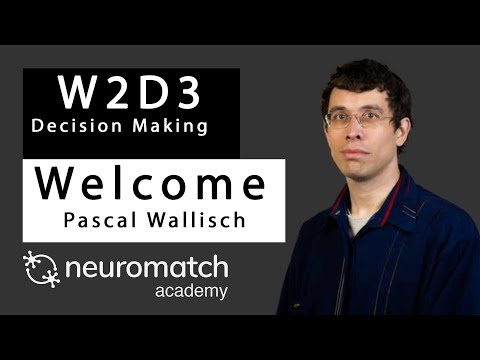

In [6]:
#@title Video: Linear Dynamical Systems
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="haDihE2_Xu0", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Latent state variable: $$s_t = Fs_{t-1}+\zeta_t$$

Measured/observed variable: $$y_t = Hs_{t}+\eta_t$$

Gaussian noise terms:

\begin{eqnarray}
\zeta_t & \sim & N(0, Q) \\
\eta_t & \sim & N(0, R) \\
s_0 & \sim & N(\mu_0, Q_0)
\end{eqnarray}

As a consequence, $s_t$, $y_t$ and their joint distributions are Gaussian so we can easily compute the marginals and conditionals.

*anything right now depends on only a time step back (Markov chain)*

Where $D<N$

## Review on Gaussian marginal and conditional distributions

Assume

\begin{eqnarray}
z & = & [x^Ty^T]^T \\
z & = & \begin{bmatrix}x \\y\end{bmatrix}\sim N\left(\begin{bmatrix}a \\b\end{bmatrix}, \begin{bmatrix}A & C \\C^T & B\end{bmatrix}\right)
\end{eqnarray}

then the marginal distributions are

\begin{eqnarray}
x & \sim & N(a, A) \\
y & \sim & N(b,B)
\end{eqnarray}

and the conditional distributions are

\begin{eqnarray}
x|y & \sim & N(a+CB^{-1}(y-b), A-CB^{-1}C^T) \\
y|x & \sim & N(b+C^TA^{-1}(x-a), B-C^TA^{-1}C)
\end{eqnarray}

*important take away: given the joint Gaussian distribution we can derive the conditionals*

## Sampling

The first thing we will investiage is how to generate timecourse samples from a linear dynamical system given its parameters. We will start by defining the following system:

In [7]:
# task dimensions
n_dim_state = 2
n_dim_obs = 2

# initialize model parameters
params = {
  'F': 0.5 * np.eye(n_dim_state),  # state transition matrix
  'Q': np.eye(n_dim_obs),  # state noise covariance
  'H': np.eye(n_dim_state),  # observation matrix
  'R': 0.1 * np.eye(n_dim_obs),  # observation noise covariance
  'mu_0': np.zeros(n_dim_state),  # initial state mean,
  'sigma_0': 0.1 * np.eye(n_dim_state),  # initial state noise covariance
}

**Note**: We used a parameter dictionary `params` above. As the number of parameters we need to provide to our functions increase, it can be beneficial to condense them into a data structure like this to clean up the number of inputs we pass in. The trade-off is we have to know what is in our data structure to use those values, rather than looking at the function signature directly.

## Exercise 1: Sampling from a linear dynamical system

In this exercise you will implement the dynamics functions of a linear dynamical system to sample both a latent space trajectory (given parameters set above) and noisy measurements.


In [8]:
def sample_lds(n_timesteps, params):
  """ Generate samples from a Linear Dynamical System specified by the provided
  parameters.

  Args:
    n_timesteps (int): the number of time steps to simulate
    params (dict): a dictionary of model paramters: (F, Q, H, R, mu_0, sigma_0)

  Returns:
    ndarray, ndarray: the generated state and observation data
  """    
  n_dim_state = params['F'].shape[0]
  n_dim_obs = params['H'].shape[0]

  # precompute random samples from the provided covariance matrices
  # mean defaults to 0
  zi = stats.multivariate_normal(cov=params['Q']).rvs(n_timesteps)
  eta = stats.multivariate_normal(cov=params['R']).rvs(n_timesteps)

  # initialize state and observation arrays
  state = np.zeros((n_timesteps, n_dim_state))
  obs = np.zeros((n_timesteps, n_dim_obs))

  ###################################################################
  ## TODO for students: compute the next state and observation values 
  ###################################################################
  # comment this out when you've filled  
  raise NotImplementedError("Student excercise: compute the next state and observation values")

  # simulate the system
  for t in range(n_timesteps):
    # write the expressions for computing state values given the time step
    if t == 0:
      state[t] = ...
    else:
      state[t] = ...
    # write the expression for computing the observation
    obs[t] = ...
  
  return state, obs


# Uncomment once the make_design_matrix function is complete
# state, obs = sample_lds(100, params)
# plot_kalman_(state, obs, title='sample')

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D3_DecisionMaking/solutions/W2D3_Tutorial3_Solution_8b04e30d.py)

*Example output:*

<img alt='Solution hint' align='left' width=953 height=406 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D3_DecisionMaking/static/W2D3_Tutorial3_Solution_8b04e30d_0.png>



## Interactive Demo:
To test your understanding of the parameters of a linear dynamical system, think about what you would expect if you made the following changes:
1. Reduce observation noise $R$
2. Increase respective temporal dynamics $F$

Use the interactive widget below to vary the values of $R$ and $F$.

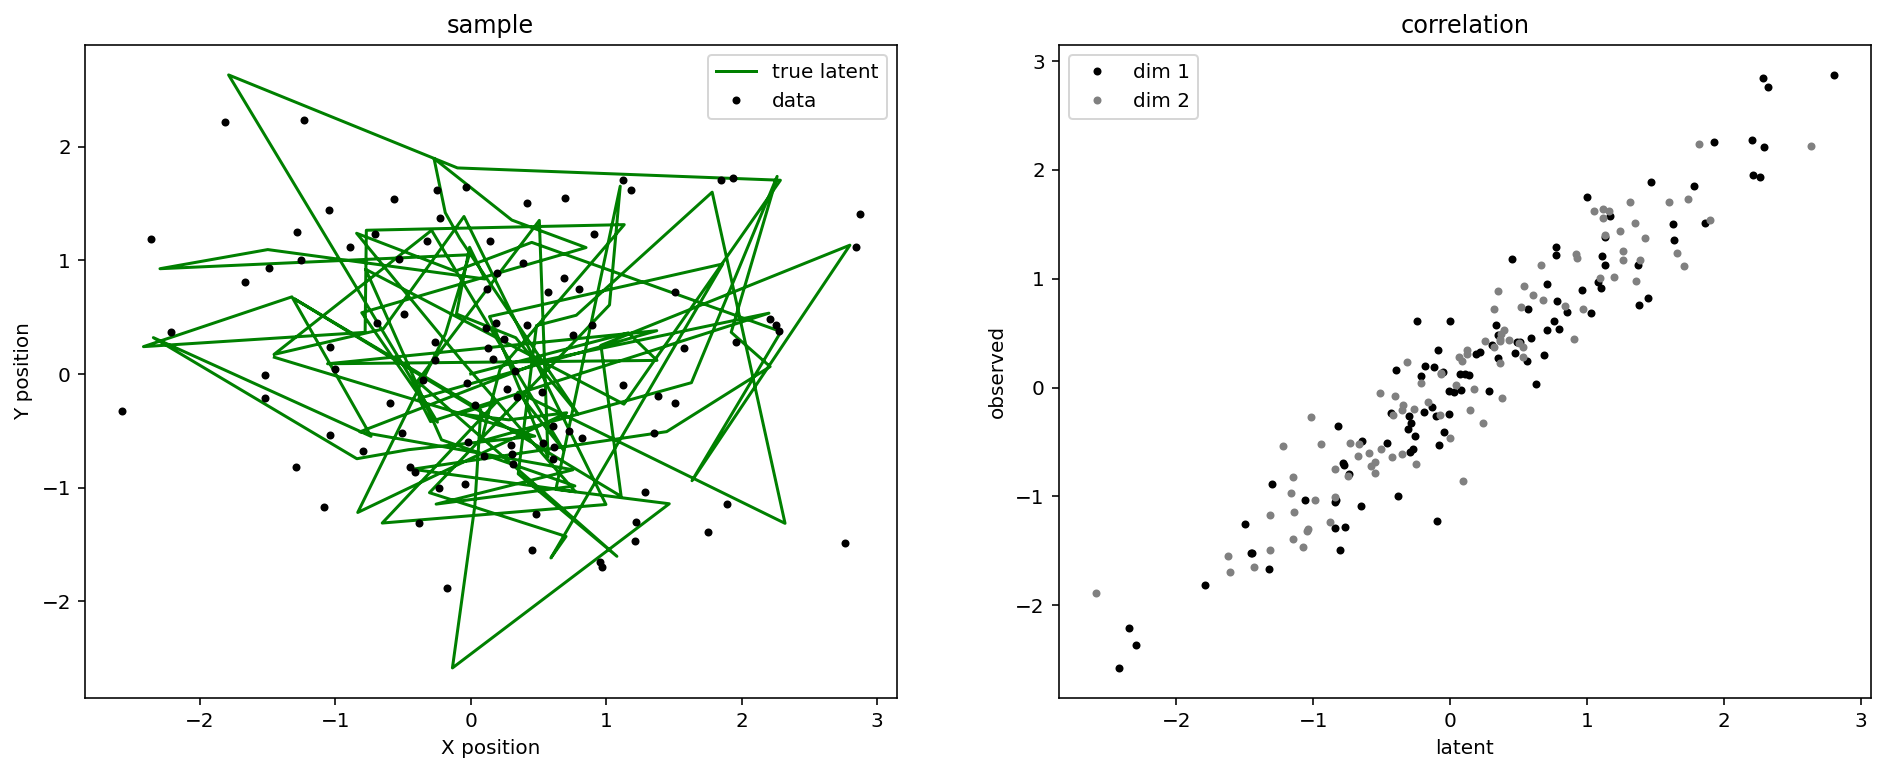

In [10]:
#@title LDS Parameter Explorer
@widgets.interact(R=widgets.FloatLogSlider(0.1, min=-3, max=1),
                  F=widgets.FloatSlider(0.5, min=0.0, max=1.0))
def explore_dynamics(R=0.1, F=0.5):
  params = {
  'F': F * np.eye(n_dim_state),  # state transition matrix
  'Q': np.eye(n_dim_obs),  # state noise covariance
  'H': np.eye(n_dim_state),  # observation matrix
  'R': R * np.eye(n_dim_obs),  # observation noise covariance
  'mu_0': np.zeros(n_dim_state),  # initial state mean,
  'sigma_0': 0.1 * np.eye(n_dim_state),  # initial state noise covariance
  }
  
  state, obs = sample_lds(100, params)
  plot_kalman_(state, obs, title='sample')

# Kalman Filtering


Video available at https://youtu.be/PMVE80_d8pQ


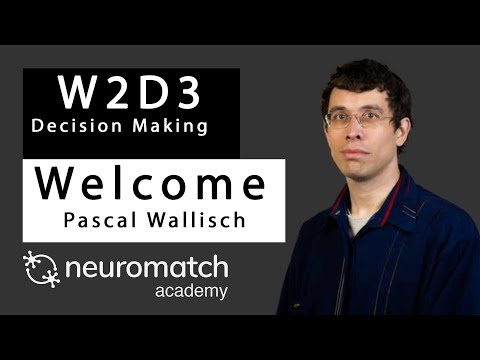

In [11]:
#@title Video: Kalman Filtering
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="PMVE80_d8pQ", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

We want to infer the latent state variable $s_t$ given the measured (observed) variable $y_t$.

$$P(s_t|y_1, ..., y_t, y_{t+1}, ..., y_T)\sim N(\hat{\mu_t}, \hat{\Sigma_t})$$

First we obtain estimates of the latent state by running the filtering from $n=0,....N$.

$$s_t^{pred}\sim N(\hat{\mu}_t^{pred},\hat{\Sigma}_t^{pred})$$

Where $\hat{\mu}_t^{pred}$ and $\hat{\Sigma}_t^{pred}$ are derived as follows:

\begin{eqnarray}
\hat{\mu}_1^{pred} & = & F\hat{\mu}_{0} \\
\hat{\mu}_t^{pred} & = & F\hat{\mu}_{t-1}
\end{eqnarray}

*this is the prediction for $s_t$ obtained simply by taking the expected value of $s_{t-1}$ and projecting it forward one step using the transition probability matrix $A$*

\begin{eqnarray}
\hat{\Sigma}_0^{pred} & = & F\hat{\Sigma}_{0}F^T+Q \\
\hat{\Sigma}_t^{pred} & = & F\hat{\Sigma}_{t-1}F^T+Q
\end{eqnarray}

*same for the covariance taking into account the noise covariance $Q$*

update from observation to obtain $\hat{\mu}_t^{filter}$ and $\hat{\Sigma}_t^{filter}$

project to observational space:
$$y_t^{pred}\sim N(H\hat{\mu}_t^{pred}, H\hat{\Sigma}_t^{pred}H^T+R)$$

update prediction by actual data:

\begin{eqnarray}
s_t^{filter} & \sim & N(\hat{\mu}_t^{filter}, \hat{\Sigma}_t^{filter}) \\
\hat{\mu}_t^{filter} & = & \hat{\mu}_t^{pred}+K_t(y_t-H\hat{\mu}_t^{pred}) \\
\hat{\Sigma}_t^{filter} & = & (I-K_tH)\hat{\Sigma}_t^{pred}
\end{eqnarray}

Kalman gain matrix: 
$$K_t=\hat{\Sigma}_t^{pred}H^T(H\hat{\Sigma}_t^{pred}H^T+R)^{-1}$$

*we use the latent-only prediction to project it to the observational space and compute a correction proportional to the error $y_t-HFz_{t-1}$ between prediction and data, coefficient of this correction is the Kalman gain matrix*

*if measurement noise is small and dynamics are fast -> estimation will depend mostly on observed data*

In order to explore the impact of filtering, we will use the following noisy periodic system:

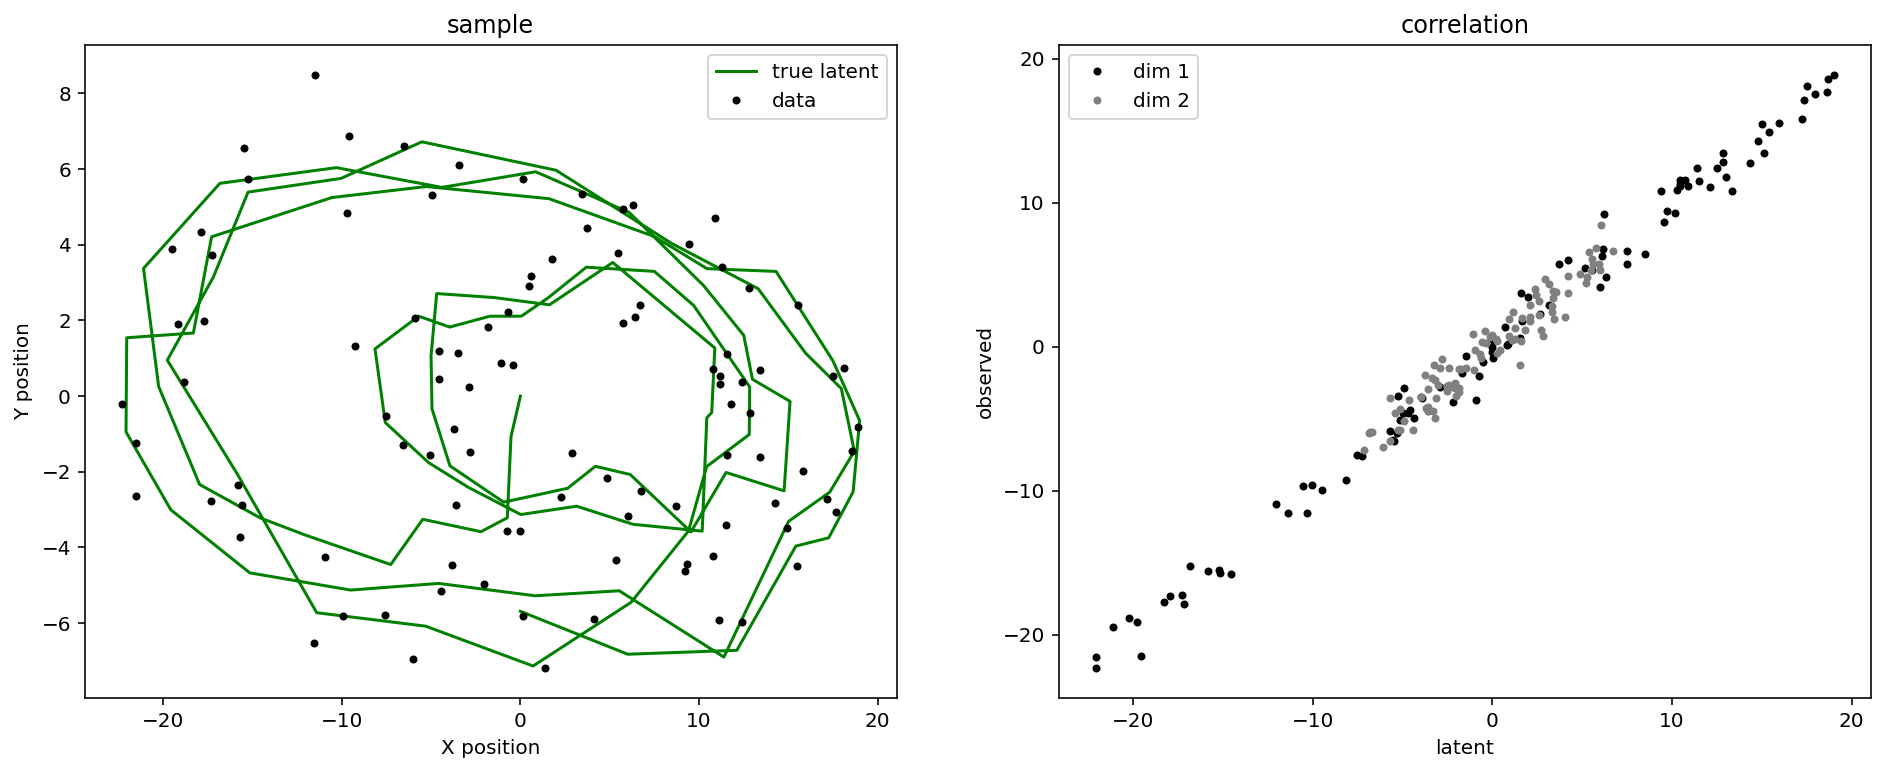

In [12]:
np.random.seed(1)

# task dimensions
n_dim_state = 2
n_dim_obs = 2

# initialize model parameters
params = {
  'F': np.array([[1., 1.], [-(2*np.pi/20.)**2., .9]]),  # state transition matrix
  'Q': np.eye(n_dim_obs),  # state noise covariance
  'H': np.eye(n_dim_state),  # observation matrix
  'R': 1.0 * np.eye(n_dim_obs),  # observation noise covariance
  'mu_0': np.zeros(n_dim_state),  # initial state mean,
  'sigma_0': 0.1 * np.eye(n_dim_state),  # initial state noise covariance
}

state, obs = sample_lds(100, params)
plot_kalman_(state, obs, title='sample')

## Exercise 2: Implement Kalman filtering
In this exercise you will implement the Kalman filter (forward) process. Your focus will be on writing the expressions for the Kalman gain, filter mean, and filter covariance at each time step (refer to the equations above).

In [13]:
def kalman_filter(data, params):
  """ Perform Kalman filtering (forward pass) on the data given the provided
  system parameters.

  Args:
    data (ndarray): a sequence of osbervations of shape(n_timesteps, n_dim_obs)    
    params (dict): a dictionary of model paramters: (F, Q, H, R, mu_0, sigma_0)

  Returns:
    ndarray, ndarray: the filtered system means and noise covariance values
  """
  # pulled out of the params dict for convenience
  F = params['F']
  Q = params['Q']
  H = params['H']
  R = params['R']

  n_dim_state = F.shape[0]
  n_dim_obs = H.shape[0]
  I = np.eye(n_dim_state)  # identity matrix

  # state tracking arrays  
  mu = np.zeros((len(data), n_dim_state))
  sigma = np.zeros((len(data), n_dim_state, n_dim_state))

  # filter the data
  for t, y in enumerate(data):
    if t == 0:
      mu_pred = params['mu_0']
      sigma_pred = params['sigma_0']
    else:
      mu_pred = F @ mu[t-1]
      sigma_pred = F @ sigma[t-1] @ F.T + Q

    ###########################################################################
    ## TODO for students: compute the filtered state mean and covariance values 
    ###########################################################################
    # comment this out when you've filled
    raise NotImplementedError("Student excercise: compute the filtered state mean and covariance values")
    # write the expression for computing the Kalman gain
    K = ...
    # write the expression for computing the filtered state mean 
    mu[t] = ...
    # write the expression for computing the filtered state noise covariance
    sigma[t] = ...

  return mu, sigma


# Uncomment once the make_design_matrix function is complete
# filtered_state_means, filtered_state_covariances = kalman_filter(obs, params)
# fig = plot_kalman(state[:,0],state[:,1],obs[:,0],obs[:,1], 
#                   filtered_state_means[:,0], filtered_state_means[:,1], "r", title ="my kf-filter", label='my kf-filter')
# plt.axis('square');

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D3_DecisionMaking/solutions/W2D3_Tutorial3_Solution_978157cb.py)

*Example output:*

<img alt='Solution hint' align='left' width=818 height=297 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D3_DecisionMaking/static/W2D3_Tutorial3_Solution_978157cb_0.png>



# Kalman Smoothing

Video available at https://youtu.be/zqDI3GLhGt0


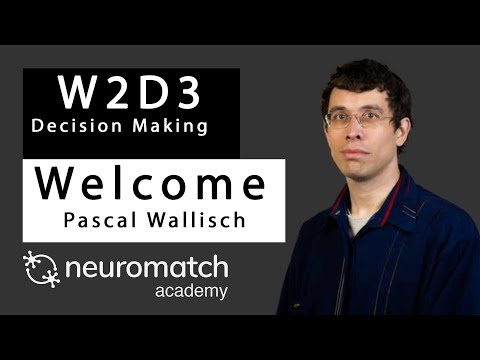

In [15]:
#@title Video: Kalman Smoothing
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="zqDI3GLhGt0", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Obtain estimates by propagating from $y_T$ back to $y_0$ using results of forward pass ($\hat{\mu}_t^{filter}, \hat{\Sigma}_t^{filter}, P_t=\hat{\Sigma}_{t+1}^{pred}$)

\begin{eqnarray}
s_t & \sim & N(\hat{\mu}_t^{smooth}, \hat{\Sigma}_t^{smooth}) \\
\hat{\mu}_t^{smooth} & = & \hat{\mu}_t^{filter}+J_t(\hat{\mu}_{t+1}^{smooth}-F\hat{\mu}_t^{filter}) \\
\hat{\Sigma}_t^{smooth} & = & \hat{\Sigma}_t^{filter}+J_t(\hat{\Sigma}_{t+1}^{smooth}-P_t)J_t^T \\
J_t & = & \hat{\Sigma}_t^{filter}F^T P_t^{-1}
\end{eqnarray}

This gives us the final estimate for $z_t$.

\begin{eqnarray}
\hat{\mu}_t & = & \hat{\mu}_t^{smooth} \\
\hat{\Sigma}_t & = & \hat{\Sigma}_t^{smooth}
\end{eqnarray}

## Exercise 3: Implement Kalman smoothing

In this exercise you will implement the Kalman smoothing (backward) process. Again you will focus on writing the expressions for computing the smoothed mean, smoothed covariance, and $J_t$ values.

In [16]:
def kalman_smooth(data, params):
  """ Perform Kalman smoothing (backward pass) on the data given the provided
  system parameters.

  Args:
    data (ndarray): a sequence of osbervations of shape(n_timesteps, n_dim_obs)    
    params (dict): a dictionary of model paramters: (F, Q, H, R, mu_0, sigma_0)

  Returns:
    ndarray, ndarray: the smoothed system means and noise covariance values
  """
  # pulled out of the params dict for convenience
  F = params['F']
  Q = params['Q']
  H = params['H']
  R = params['R']

  n_dim_state = F.shape[0]
  n_dim_obs = H.shape[0]
  
  # first run the forward pass to get the filtered means and covariances
  mu, sigma = kalman_filter(data, params)

  # initialize state mean and covariance estimates
  mu_hat = np.zeros_like(mu)
  sigma_hat = np.zeros_like(sigma)
  mu_hat[-1] = mu[-1]
  sigma_hat[-1] = sigma[-1]
  
  # smooth the data
  for t in reversed(range(len(data)-1)):
    sigma_pred = F @ sigma[t] @ F.T + Q  # sigma_pred at t+1
    ###########################################################################
    ## TODO for students: compute the smoothed state mean and covariance values 
    ###########################################################################
    # comment this out when you've filled
    raise NotImplementedError("Student excercise: compute the smoothed state mean and covariance values")
    # write the expression to compute the Kalman gain for the backward process
    J = ...
    # write the expression to compute the smoothed state mean estimate
    mu_hat[t] = ...
    # write the expression to compute the smoothed state noise covariance estimate
    sigma_hat[t] = ...

  return mu_hat, sigma_hat


# Uncomment once the make_design_matrix function is complete
# smoothed_state_means, smoothed_state_covariances = kalman_smooth(obs, params)
#   ax = plot_kalman(state[:,0],state[:,1],obs[:,0],obs[:,1], 
#                 filtered_state_means[:,0], filtered_state_means[:,1], "r", label="my kf-filter")
#   _ = plot_kalman(state[:,0],state[:,1],obs[:,0],obs[:,1], 
#                 smoothed_state_means[:,0], smoothed_state_means[:,1], "b", label="my kf-smoothed", ax=ax)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D3_DecisionMaking/solutions/W2D3_Tutorial3_Solution_df9f85f7.py)

*Example output:*

<img alt='Solution hint' align='left' width=819 height=297 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D3_DecisionMaking/static/W2D3_Tutorial3_Solution_df9f85f7_0.png>



## Forward vs Backward

Now that we have implementations for both, let's compare their peformance by computing the MSE between the filtered (forward) and smoothed (backward) estimated states and the true latent state.

In [18]:
print(f"Filtered MSE: {np.mean((state - filtered_state_means)**2):.3f}")
print(f"Smoothed MSE: {np.mean((state - smoothed_state_means)**2):.3f}")

Filtered MSE: 0.662
Smoothed MSE: 0.483


In this example, the smoothed estimate is clearly superior to the filtered one. This makes sense as the backward pass is able to use the forward pass estimates and correct them given all the data we've collected.

So why would you ever use Kalman filtering instead of smoothing? As Kalman filtering only depends on already observed data (i.e. the past) it can be run in a streaming, or on-line, setting. Kalman smoothing relies on future data as it were, and as such can only be applied in a batch, or off-line, setting. So use Kalman filtering if you need real-time corrections and Kalman smoothing if you are considering already-collected data.

# The Expectation-Maximization (EM) Algorithm

Video available at https://youtu.be/hPUsBqm4C4E


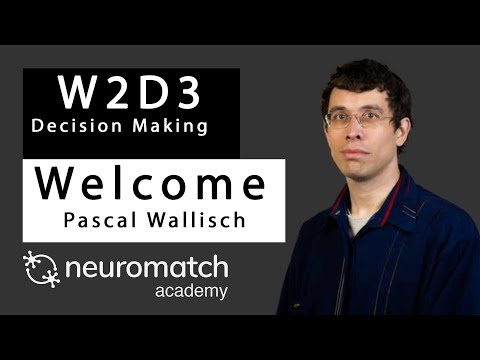

In [19]:
#@title Video: The EM Algorithm
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="hPUsBqm4C4E", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

- want to maximize $log p(y|\theta)$

- need to marginalize out latent state *(which is not tractable)*

$$p(y|\theta)=\int p(y,s|\theta)dz$$

- add a probability distribution $q(s)$ which will approximate the latent state distribution 

$$log p(y|\theta)\int_s q(s)dz$$

- can be rewritten as

$$\mathcal{L}(q,\theta)+KL\left(q(s)||p(s|y),\theta\right)$$

- $\mathcal{L}(q,\theta)$ contains the joint distribution of $y$ and $s$

- $KL(q||p)$ contains the conditional distribution of $s|y$

#### Expectation step
- parameters are kept fixed
- find a good approximation $q(s)$: maximize lower bound $\mathcal{L}(q,\theta)$ with respect to $q(s)$
- (already implemented Kalman filter+smoother)

#### Maximization step
- keep distribution $q(s)$ fixed
- change parameters to maximize the lower bound $\mathcal{L}(q,\theta)$

As mentioned, we have already effectively solved for the E-Step with our Kalman filter and smoother. The M-step requires further derivation, which is covered in the Appendix. Rather than having you implement the M-Step yourselves, let's instead turn to using a library that has already implemented EM for exploring some experimental data from cognitive neuroscience.




# Fitting Gaze Data

Let's look at how we can use Kalman filtering to smooth out eye tracking data on a [visual saliency](http://www.scholarpedia.org/article/Visual_salience) task. Noise can come from a number of places, a main one being the general accuracy of the eye tracker device and its ability to consistently map eye position to screen pixels. These sensors need to be calibrated (and recalibrated) during tasks to ensure accurate data from a subject, while  changes in ambient light can also throw them off. Another source of noise comes from the subject themselves in the form of eye blinks. How eye blinks are represented by the eye tracker in the data stream will affect the mitigation strategy. In our case, we will use masked arrays to avoid the blinks (see Appendix).

The data we will be exploring is from the [MIT Eyetracking Database](http://people.csail.mit.edu/tjudd/WherePeopleLook/index.html) [[Judd et al. 2009](http://people.csail.mit.edu/tjudd/WherePeopleLook/Docs/wherepeoplelook.pdf)]. We have three stimulus images and five different subjects' data. You can use the widget below to see how different subjects scanned the image. A subject ID of -1 will show the stimulus images without any overlayed gaze trace. 

Note that the images are rescaled for display purposes, they were in their original aspect ratio during the task itself.

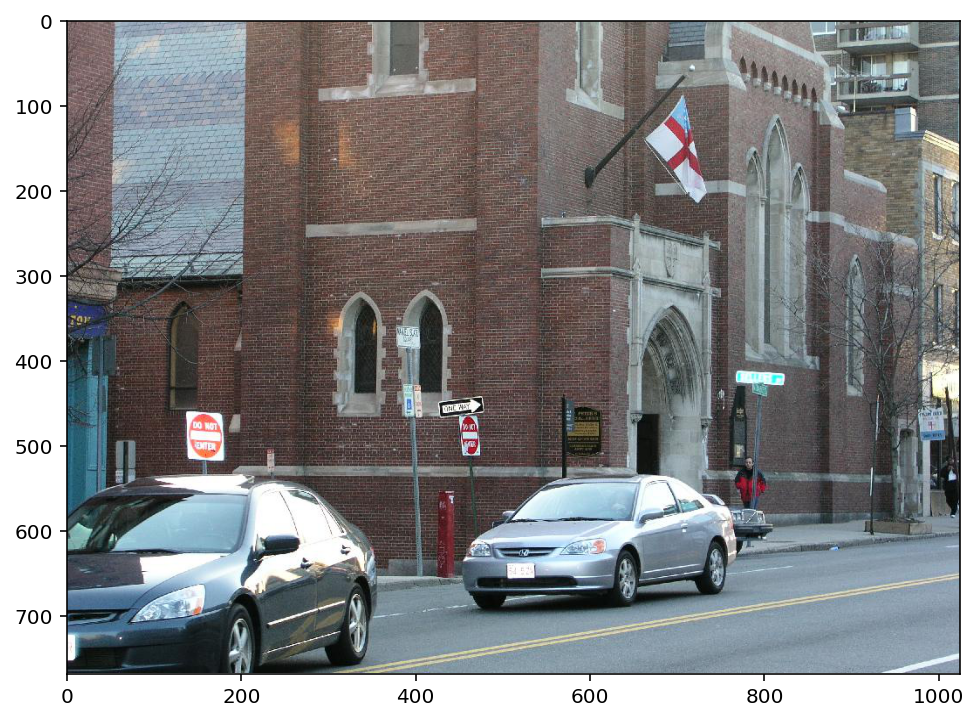

In [20]:
#@title Gaze Data Explorer
@widgets.interact(subject_id=widgets.IntSlider(-1, min=-1, max=4),
                  image_id=widgets.IntSlider(0, min=0, max=2))
def plot_subject_trace(subject_id=-1, image_id=0):
  if subject_id == -1:
    subject = np.zeros((3, 0, 2))
  else:
    subject = et_subjects[subject_id]
  data = subject[image_id]
  img = et_images[image_id]

  fig, ax = plt.subplots()
  ax.imshow(img, aspect='auto')
  ax.scatter(data[:, 0], data[:, 1], c='m', s=100, alpha=0.7)
  ax.set(xlim=(0, img.shape[1]), ylim=(img.shape[0], 0))

## The `pykalman` Library

pykalman is a ready-made Python library for working with linear dynamical systems. In addition to the sampling, filtering, and smoothing methods we already implemented, it also handles the EM estimation of parameters.

Before exploring fitting models with `pykalman` it's worth pointing out some naming conventions used by the libary:

$$
\begin{align}
F &: \texttt{transition_matrices} & 
Q &: \texttt{transition_covariance}\\
H &:\texttt{observation_matrices} &
R &:\texttt{observation_covariance}\\
\mu_0 &: \texttt{inital_state_mean} & \Sigma_0 &: \texttt{inital_state_covariance}
\end{align}
$$

Let's start by assuming the dynamics of the latent state are entirely described by the pixel coordinates and set the state dimension to 2. Because we know from the reported experimental design that subjects fixated in the center of the screen right before the image appears, we can set the initial starting state as being the center pixel of the stimulus image with a correspondingly low initial noise covariance. Once set, we will let the EM algorithm discover the rest of the dynamics parameters i.e. the $F$, $Q$, $H$, and $R$ matrices.

In [21]:
# set up our KalmanFilter object and tell it which parameters we want to
# estimate
np.random.seed(1)

n_dim_obs = 2
n_dim_state = 2

kf = KalmanFilter(
  n_dim_state=n_dim_state, 
  n_dim_obs=n_dim_obs,    
  em_vars=['transition_matrices', 'transition_covariance',
           'observation_matrices', 'observation_covariance']
)

In [22]:
# Let's choose the first subject and stimulus image
subject_id = 0
image_id = 0
data = et_subjects[subject_id][image_id]

kf.initial_state_mean = data[0]
kf.initial_state_covariance = 0.1*np.eye(n_dim_state)

kf.em(data)

print(f'F =\n{kf.transition_matrices}')
print(f'Q =\n{kf.transition_covariance}')
print(f'H =\n{kf.observation_matrices}')
print(f'R =\n{kf.observation_covariance}')

F =
[[ 1.000e+00 -1.517e-03]
 [ 4.528e-04  9.982e-01]]
Q =
[[96.415 48.355]
 [48.355 71.439]]
H =
[[ 1.000e+00 -3.335e-04]
 [-9.432e-04  1.002e+00]]
R =
[[13.225 11.727]
 [11.727 12.023]]


We see that the EM algorithm has found fits for the various dynamics parameters. We can now use these to smooth the observation. We can also see how these work with the gaze recorded by the same subject on the other images as well.

Below are the three stimulus images overlayed with recorded gaze in magenta and smoothed state from the filter in green, with gaze begin (orange triangle) and gaze end (orange square) markers. 

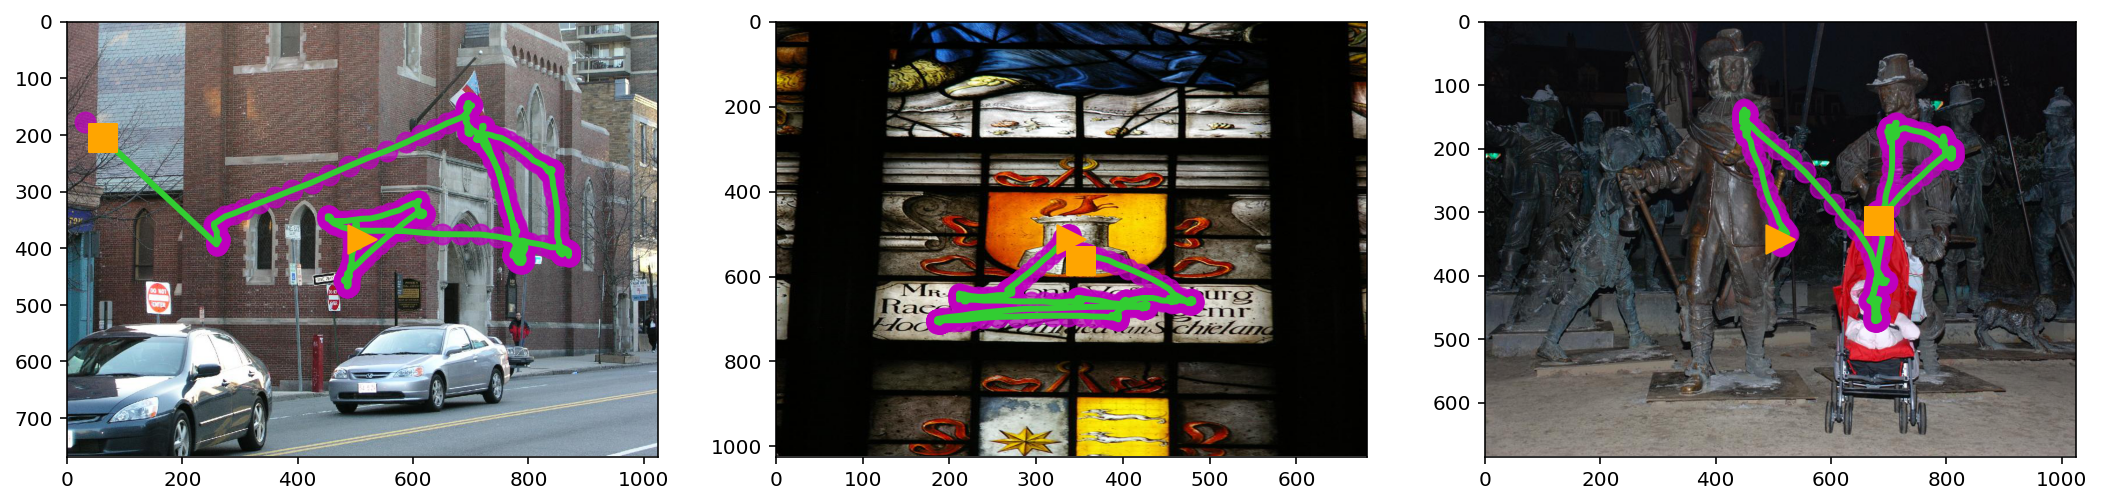

In [23]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 4))    
for data, img, ax in zip(et_subjects[subject_id], et_images, axes):
  ax = plot_gaze_data(data, img=img, ax=ax)
  plot_kf_state(kf, data, ax)

Recall that the orignial task was to use this data to help devlop models of visual salience. While our Kalman filter is able to provide smooth estimates of observed gaze data, it's not telling us anything about *why* the gaze is going in a certain direction. In fact, if we sample data from our parameters and plot them, we get what amounts to a random walk.

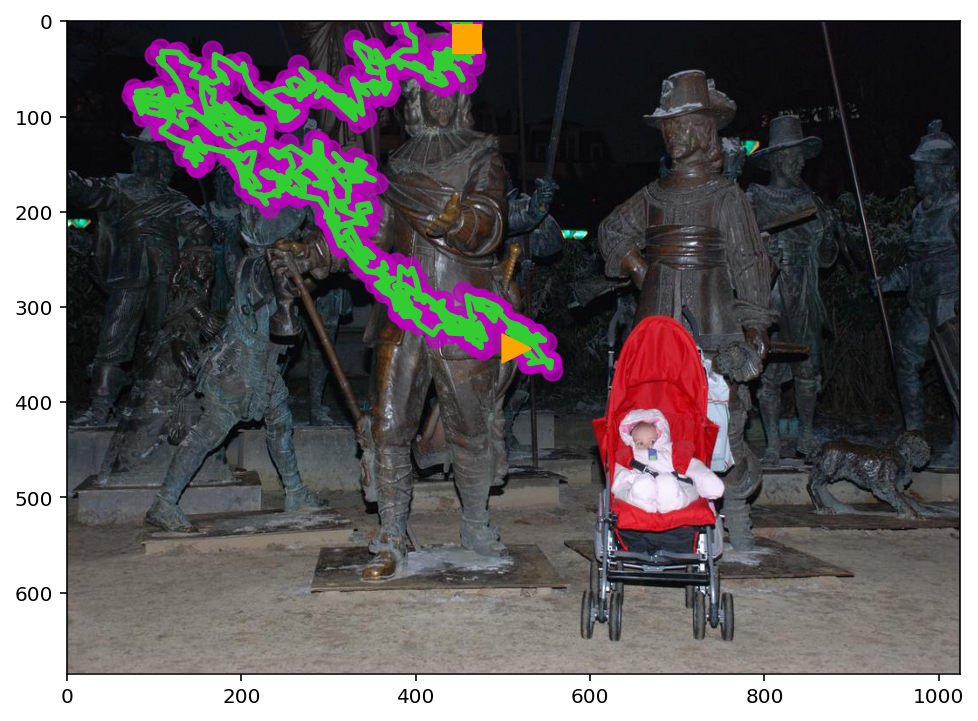

In [24]:
kf_state, kf_data = kf.sample(len(data))
ax = plot_gaze_data(kf_data, img=et_images[2])
plot_kf_state(kf, kf_data, ax)

This should not be surprising, as we have given the model no other observed data beyond the pixels at which gaze was detected. We expect there is some other aspect driving the latent state of where to look next other than just the previous fixation location.

Rather than dealing with the image data itself, what if there were just another latent variable to the state? We can see the effects of this assumption by fitting our filter with additional state dimensions beyond the pixels. In this case the first two elements of the initial state mean are still the center pixel coordinates, while the remaining elements are randomly sampled from a standard normal distribution.

In [25]:
subject_id = 3
image_id = 2
data = et_subjects[subject_id][image_id]
filters = [fit_kalman_filter(data, n_dim_state=n) for n in (2, 3, 4)]

print(f'Q_2 =\n{filters[0].transition_covariance}')
print(f'Q_3 =\n{filters[1].transition_covariance}')
print(f'Q_4 =\n{filters[2].transition_covariance}')

Q_2 =
[[53.623  9.865]
 [ 9.865 80.382]]
Q_3 =
[[ 5.153e+01  8.659e+00 -3.381e-02]
 [ 8.659e+00  7.968e+01 -1.346e-02]
 [-3.381e-02 -1.346e-02  1.008e+00]]
Q_4 =
[[ 48.27    2.663   8.503  11.133]
 [  4.741  73.224   9.052  12.928]
 [ -2.645  -2.891   7.539 -62.383]
 [ -2.585  -3.288  72.793   4.03 ]]


The EM algorithm does indeed find values to fit our parameters. How does this affect our ability to generate new gaze traces?

/opt/hostedtoolcache/Python/3.7.7/x64/lib/python3.7/site-packages/pykalman/standard.py:1126: RuntimeWarning: covariance is not positive-semidefinite.
  observation_covariance.newbyteorder('=')
/opt/hostedtoolcache/Python/3.7.7/x64/lib/python3.7/site-packages/pykalman/standard.py:1108: RuntimeWarning: covariance is not positive-semidefinite.
  transition_covariance.newbyteorder('=')


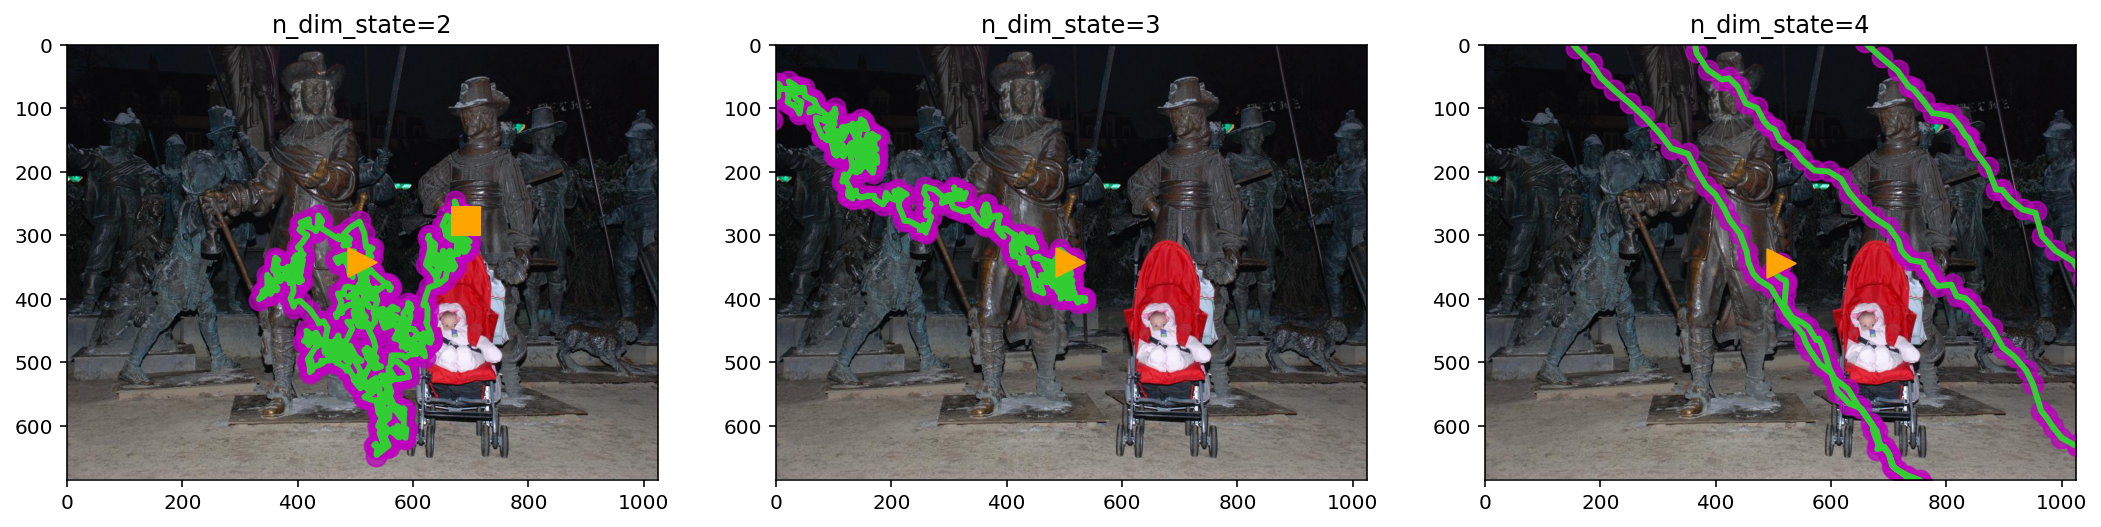

In [26]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 4))    
for kf_d, ax in zip(filters, axes):
  _, kf_data = kf_d.sample(len(data))
  ax = plot_gaze_data(kf_data, img=et_images[image_id], ax=ax)
  plot_kf_state(kf_d, kf_data, ax)
  ax.set(title=f'n_dim_state={kf_d.n_dim_state}')

Adding the additional latent states does indeed seem to have an effect on the overall "gaze" dynamics, however it still has no bearing on anything we would consider capturing actual saliency because, again, we have included no information about the image itself.

A possible next extension would be to include some representation of the image data in our observation samples -- maybe the local luminence gradient near the fixation point or entropy calculations of tiled image sections. 

Before we get carried away, it's important to step back and think what the implications of fitting a model like this would say about cognition and the brain -- that visual saliency and thus gaze is controlled entirely by external factors in a bottom-up way with no consideration to top-down endogenous factors e.g. attention. 

While the Kalman filter is a good option for smoothing the gaze trajectory itself, especially if using a lower-quality eye tracker or in noisy environmental conditions, LDS may not be the right way to approach modeling visual saliency.

# Appendix

## The M-step for a LDS
*(see Bishop, chapter 13.3.2 Learning in LDS)*
Update parameters of the probability distribution

*For the updates in the M-step we will need the following posterior marginals obtained from the Kalman smoothing results* $\hat{\mu}_t^{smooth}, \hat{\Sigma}_t^{smooth}$

$$
\begin{eqnarray}
E(s_t) &=& \hat{\mu}_t \\
E(s_ts_{t-1}^T) &=& J_{t-1}\hat{\Sigma}_t+\hat{\mu}_t\hat{\mu}_{t-1}^T\\
E(s_ts_{t}^T) &=& \hat{\Sigma}_t+\hat{\mu}_t\hat{\mu}_{t}^T
\end{eqnarray}
$$

**Update parameters**

Initial parameters
$$
\begin{eqnarray}
\mu_0^{new}&=& E(s_0)\\
Q_0^{new} &=& E(s_0s_0^T)-E(s_0)E(s_0^T) \\
\end{eqnarray}
$$

Hidden (latent) state parameters
$$
\begin{eqnarray}
F^{new} &=& \left(\sum_{t=2}^N E(s_ts_{t-1}^T)\right)\left(\sum_{t=2}^N E(s_{t-1}s_{t-1}^T)\right)^{-1} \\
Q^{new} &=& \frac{1}{T-1} \sum_{t=2}^N E\big(s_ts_t^T\big) - F^{new}E\big(s_{t-1}s_{t}^T\big) - E\big(s_ts_{t-1}^T\big)F^{new}+F^{new}E\big(s_{t-1}s_{t-1}^T\big)\big(F^{new}\big)^{T}\\
\end{eqnarray}
$$

Observable (measured) space parameters
$$H^{new}=\left(\sum_{t=1}^N y_t E(s_t^T)\right)\left(\sum_{t=1}^N E(s_t s_t^T)\right)^{-1}$$
$$R^{new}=\frac{1}{T}\sum_{t=1}^Ny_ty_t^T-H^{new}E(s_t)y_t^T-y_tE(s_t^T)H^{new}+H^{new}E(s_ts_t^T)H_{new}$$

## Handling Eye Blinks

In the MIT Eyetracking Database, raw tracking data includes times when the subject blinked. The way this is represented in the data stream is via negative pixel coordinate values.

We could try to mitigate these samples by simply deleting them from the stream, though this introduces other issues. For instance, if each sample corresponds to a fixed time step, and you arbitrarily remove some samples, the integrity of that consistent timestep between samples is lost. It's sometimes better to flag data as missing rather than to pretend it was never there at all, especially with time series data.

Another solution is to used masked arrays. In `numpy`, a [masked array](https://numpy.org/doc/stable/reference/maskedarray.generic.html#what-is-a-masked-array) is an `ndarray` with an additional embedded boolean masking array that indicates which elements should be masked. When computation is performed on the array, the masked elements are ignored. Both `matplotlib` and `pykalman` work with masked arrays, and, in fact, this is the approach taken with the data we explore in this notebook. 

In preparing the dataset for this noteook, the original dataset was preprocessed to set all gaze data as masked arrays, with the mask enabled for any pixel with a negative x or y coordinate.